In [461]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, RobustScaler
import pickle
import os
import glob
import seaborn as sns

In [462]:
data = pd.read_csv(r'../data/df_features_combined.csv')
data = data[['memberID', 'holdtime', 'pack_name', 'pieces_d1', 'pieces_d2', 'pieces_d3', 'pieces_d4', 'num_puzzles', 'difficulty_rating_1', 'difficulty_rating_2']]
data = data.rename({'memberID':'member', 'holdtime':'hold_time', 'difficulty_rating_1':'diff_0', 'difficulty_rating_2':'diff_1'}, axis=1)

In [463]:
data.head()

,member,hold_time,pack_name,pieces_d1,pieces_d2,pieces_d3,pieces_d4,num_puzzles,diff_0,diff_1
0,member1,2.939411,Artifact Puzzles Justin Hillgrove Word Travels...,456,548,0,0,2,1,2
1,member1,0.998885,DaVici Puzzles Full Moon Feast DaVici Puzzles ...,195,0,220,0,2,1,3
2,member1,10.865032,DaVici Puzzles Flying Frigate DaVici Puzzles H...,496,0,0,0,2,1,1
3,member1,22.083971,Liberty Puzzles Haeckel Hummingbirds Nautilus ...,0,707,0,0,2,2,2
4,member1,5.077603,DaVici Puzzles Diana Zimens City Of Cats,0,700,0,0,1,2,2


In [464]:
def member_train_test_split(df, test_size = 0.25):
    """
    Creates train and test sets per member based on test_size
    assumes rows are in time order so does not shuffle
    """
    train_size = (1 - test_size)
    g = df.groupby('member')
    train_flags = (g.cumcount() + 1) <= g.transform('size') * train_size
    test_flags = (g.cumcount() + 1) > g.transform('size') * train_size
    
    # Split X and y (hold_time)
    X_train = df[train_flags].drop('hold_time', axis=1)
    X_test = df[test_flags].drop('hold_time', axis=1)
    y_train = df[train_flags].hold_time
    y_test = df[test_flags].hold_time
    
    return X_train, X_test, y_train, y_test

In [465]:
# Split train/test
X_train, X_test, y_train, y_test = member_train_test_split(data)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(14278, 9) (14278,) (5109, 9) (5109,)


In [466]:
"""
Replaced with order based split to account for time
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(data.drop('hold_time', axis=1), data['hold_time'], random_state = 123)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
"""

"\nReplaced with order based split to account for time\n# Split train/test\nX_train, X_test, y_train, y_test = train_test_split(data.drop('hold_time', axis=1), data['hold_time'], random_state = 123)\nprint(X_train.shape, y_train.shape, X_test.shape, y_test.shape)\n"

In [467]:
# Dropping difficulty as difficulty should be encoded by splitting piece counts up by difficulty
X_train = X_train.drop(['diff_0', 'diff_1'], axis=1)
X_test = X_test.drop(['diff_0', 'diff_1'], axis=1)

In [468]:
print(len(X_train))
print(len(X_train[X_train.isna().any(axis=1)]))
print(len(X_train[X_train.notna().all(axis=1)]))

14278
0
14278


In [469]:
print(len(X_test))
print(len(X_test[X_test.isna().any(axis=1)]))
print(len(X_test[X_test.notna().all(axis=1)]))

5109
0
5109


In [470]:
# Handle puzzles with no info, this is quite common
# Drop them from training as to not introduce non-existant signal
y_train = y_train[X_train.notna().all(axis=1)]
X_train = X_train[X_train.notna().all(axis=1)]

# Can't drop from test as we still need to predict something for these people
# Try filling with median?
X_test_not_missing = X_test.notna().all(axis=1)
X_test['pieces_d1'] = X_test.pieces_d1.fillna(X_train.pieces_d1.mean())
X_test['pieces_d2'] = X_test.pieces_d2.fillna(X_train.pieces_d2.mean())
X_test['pieces_d3'] = X_test.pieces_d3.fillna(X_train.pieces_d3.mean())
X_test['pieces_d4'] = X_test.pieces_d4.fillna(X_train.pieces_d4.mean())
X_test.num_puzzles = X_test.num_puzzles.fillna(2) # just doing this manually as basically every pack has 2 puzzles

In [471]:
# Calculate global distribution info for each puzzle
full_training_set = X_train.copy()
full_training_set['hold_time'] = y_train.copy()
hold_summary_by_pack = full_training_set.groupby(by=['pack_name'])['hold_time'].describe()

# Some packs only have 1 data point so std dev is NaN, fill with avg std dev from the entire set
hold_summary_by_pack['std'] = hold_summary_by_pack['std'].fillna(hold_summary_by_pack['std'].mean())

# There are likely going to be instances in the test set where we don't have data for a pack, use the global averages for now
# TODO come up with a more sophisticated way to handle packs we don't have data for

In [472]:
X_test[X_test.isna().any(axis=1)]

,member,pack_name,pieces_d1,pieces_d2,pieces_d3,pieces_d4,num_puzzles


In [473]:
# Join the training data with the per pack info, just going to use mean and std for now
# TODO try out other variations on pack hold-time distribution information
X_train = pd.merge(X_train, hold_summary_by_pack[['count','std', 'mean']], left_on='pack_name', right_index=True, how='left')
X_train['pack_hold_time_std'] = X_train['std']
X_train['pack_hold_time_mean'] = X_train['mean']
X_train['pack_hold_time_count'] = X_train['count']
X_train = X_train.drop(['std', 'mean', 'count'], axis=1)



In [474]:
X_train[X_train.isna().any(axis=1)]

,member,pack_name,pieces_d1,pieces_d2,pieces_d3,pieces_d4,num_puzzles,pack_hold_time_std,pack_hold_time_mean,pack_hold_time_count


In [475]:
# Add pack hold_time avg and std dev from training set to test set data
X_test = pd.merge(X_test, hold_summary_by_pack[['count', 'std', 'mean']], left_on='pack_name', right_index=True, how='left')
X_test['pack_hold_time_std'] = X_test['std']
X_test['pack_hold_time_mean'] = X_test['mean']
X_test['pack_hold_time_count'] = X_test['count']
X_test = X_test.drop(['mean', 'std', 'count'], axis=1)

# For packs from the test set with pack hold time data, fill with the means from the hold_time summary created using only training data
X_test['pack_hold_time_mean'] = X_test['pack_hold_time_mean'].fillna(hold_summary_by_pack['mean'].mean())
X_test['pack_hold_time_std'] = X_test['pack_hold_time_std'].fillna(hold_summary_by_pack['std'].mean())
X_test['pack_hold_time_count'] = X_test['pack_hold_time_count'].fillna(hold_summary_by_pack['count'].mean())

In [476]:
# Similar hold time distribution info per member, if hold-time data not present use global avg
hold_summary_by_member = full_training_set.groupby(by='member')['hold_time'].describe()
X_train = pd.merge(X_train, hold_summary_by_member[['count', 'mean', 'std']].rename(columns={'count': 'member_hold_time_count', 'mean': 'member_hold_time_mean', 'std': 'member_hold_time_std'}), left_on='member', right_index=True, how='left')
X_test = pd.merge(X_test, hold_summary_by_member[['count', 'mean', 'std']].rename(columns={'count': 'member_hold_time_count', 'mean': 'member_hold_time_mean', 'std': 'member_hold_time_std'}), left_on='member', right_index=True, how='left')

# For missing hold time summary data impute with global avg of the training set
#Filling train
X_train['member_hold_time_mean'] = X_train['member_hold_time_mean'].fillna(hold_summary_by_member['mean'].mean())
X_train['member_hold_time_std'] = X_train['member_hold_time_std'].fillna(hold_summary_by_member['std'].mean())
X_train['member_hold_time_count'] = X_train['member_hold_time_count'].fillna(hold_summary_by_member['count'].mean())
# Filling test
X_test['member_hold_time_mean'] = X_test['member_hold_time_mean'].fillna(hold_summary_by_member['mean'].mean())
X_test['member_hold_time_std'] = X_test['member_hold_time_std'].fillna(hold_summary_by_member['std'].mean())
X_test['member_hold_time_count'] = X_test['member_hold_time_count'].fillna(hold_summary_by_member['count'].mean())


In [477]:
X_train['tmp'] = train_index = X_train.index
X_test['tmp'] = test_index = X_test.index

X_train = X_train.merge(full_training_set.groupby('member')['hold_time'].median(), left_on=['member'], right_index=True, suffixes=['', '_median']).rename({'hold_time': 'hold_time_median'}, axis=1)
X_train = X_train.merge(full_training_set.groupby('member')['hold_time'].rolling(5).median(), right_index=True, left_on=['member', 'tmp'], suffixes=['', '_rolling_median']).rename({'hold_time': 'hold_time_rolling_median'}, axis=1)
X_train = X_train.drop('tmp', axis=1)
X_train['hold_time_rolling_median'] = X_train['hold_time_rolling_median'].fillna(X_train.hold_time_median)

X_test = X_test.merge(full_training_set.groupby('member')['hold_time'].median(), how='left', left_on=['member'], right_index=True, suffixes=['', '_median']).rename({'hold_time': 'hold_time_median'}, axis=1)
X_test = X_test.merge(X_test.join(y_test).groupby('member')['hold_time'].rolling(5).median(), left_on=['member', 'tmp'], right_index=True, suffixes=['', '_rolling_median']).rename({'hold_time': 'hold_time_rolling_median'}, axis=1)
X_test['hold_time_median'] = X_test.hold_time_median.fillna(y_train.median())
X_test = X_test.drop('tmp', axis=1)
X_test['hold_time_rolling_median'] = X_test['hold_time_rolling_median'].fillna(X_test.hold_time_median)


In [478]:
X_test[X_test.isna().any(axis=1)]

,member,pack_name,pieces_d1,pieces_d2,pieces_d3,pieces_d4,num_puzzles,pack_hold_time_std,pack_hold_time_mean,pack_hold_time_count,member_hold_time_count,member_hold_time_mean,member_hold_time_std,hold_time_median,hold_time_rolling_median


In [479]:
# Adding in another feature which is just the global mean hold time
X_train['global_hold_time_mean'] = y_train.mean()
X_test['global_hold_time_mean'] = y_train.mean()

array([[<AxesSubplot: title={'center': 'mean'}>]], dtype=object)

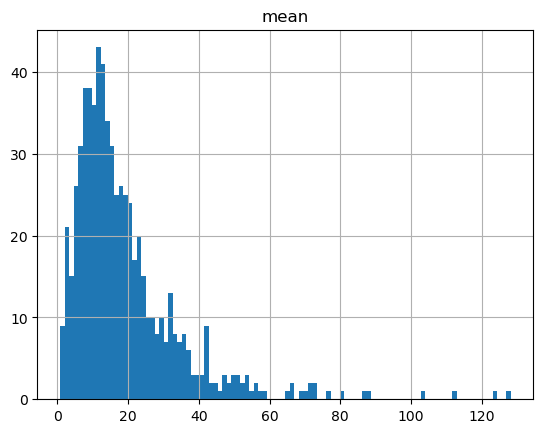

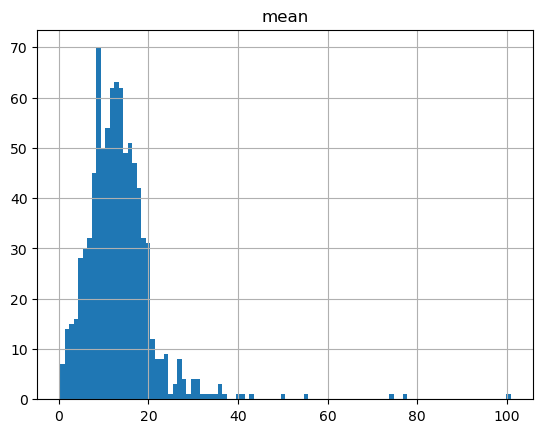

In [480]:
hold_summary_by_member.hist('mean', bins=100)
hold_summary_by_pack.hist('mean', bins=100)

                                           pack_name  pieces_d1  pieces_d2  \
0  Artifact Puzzles Justin Hillgrove Word Travels...        456        548   
1  DaVici Puzzles Full Moon Feast DaVici Puzzles ...        195          0   
2  DaVici Puzzles Flying Frigate DaVici Puzzles H...        496          0   
3  Liberty Puzzles Haeckel Hummingbirds Nautilus ...          0        707   
4          DaVici Puzzles Diana Zimens City Of Cats           0        700   

   pieces_d3  pieces_d4  num_puzzles  pack_hold_time_std  pack_hold_time_mean  \
0          0          0            2           21.675581            17.142370   
1        220          0            2           18.964706            11.681465   
2          0          0            2           13.243527            10.685779   
3          0          0            2           23.716058            18.297648   
4          0          0            1            8.259022            10.082138   

   pack_hold_time_count  member_hold_time_co

/var/folders/vs/2pyq73711mgf5lg0y3w7rllm0000gn/T/ipykernel_24052/802187159.py:13: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataplot = sns.heatmap(X_train_numeric.corr(), cmap="YlGnBu", annot=True)


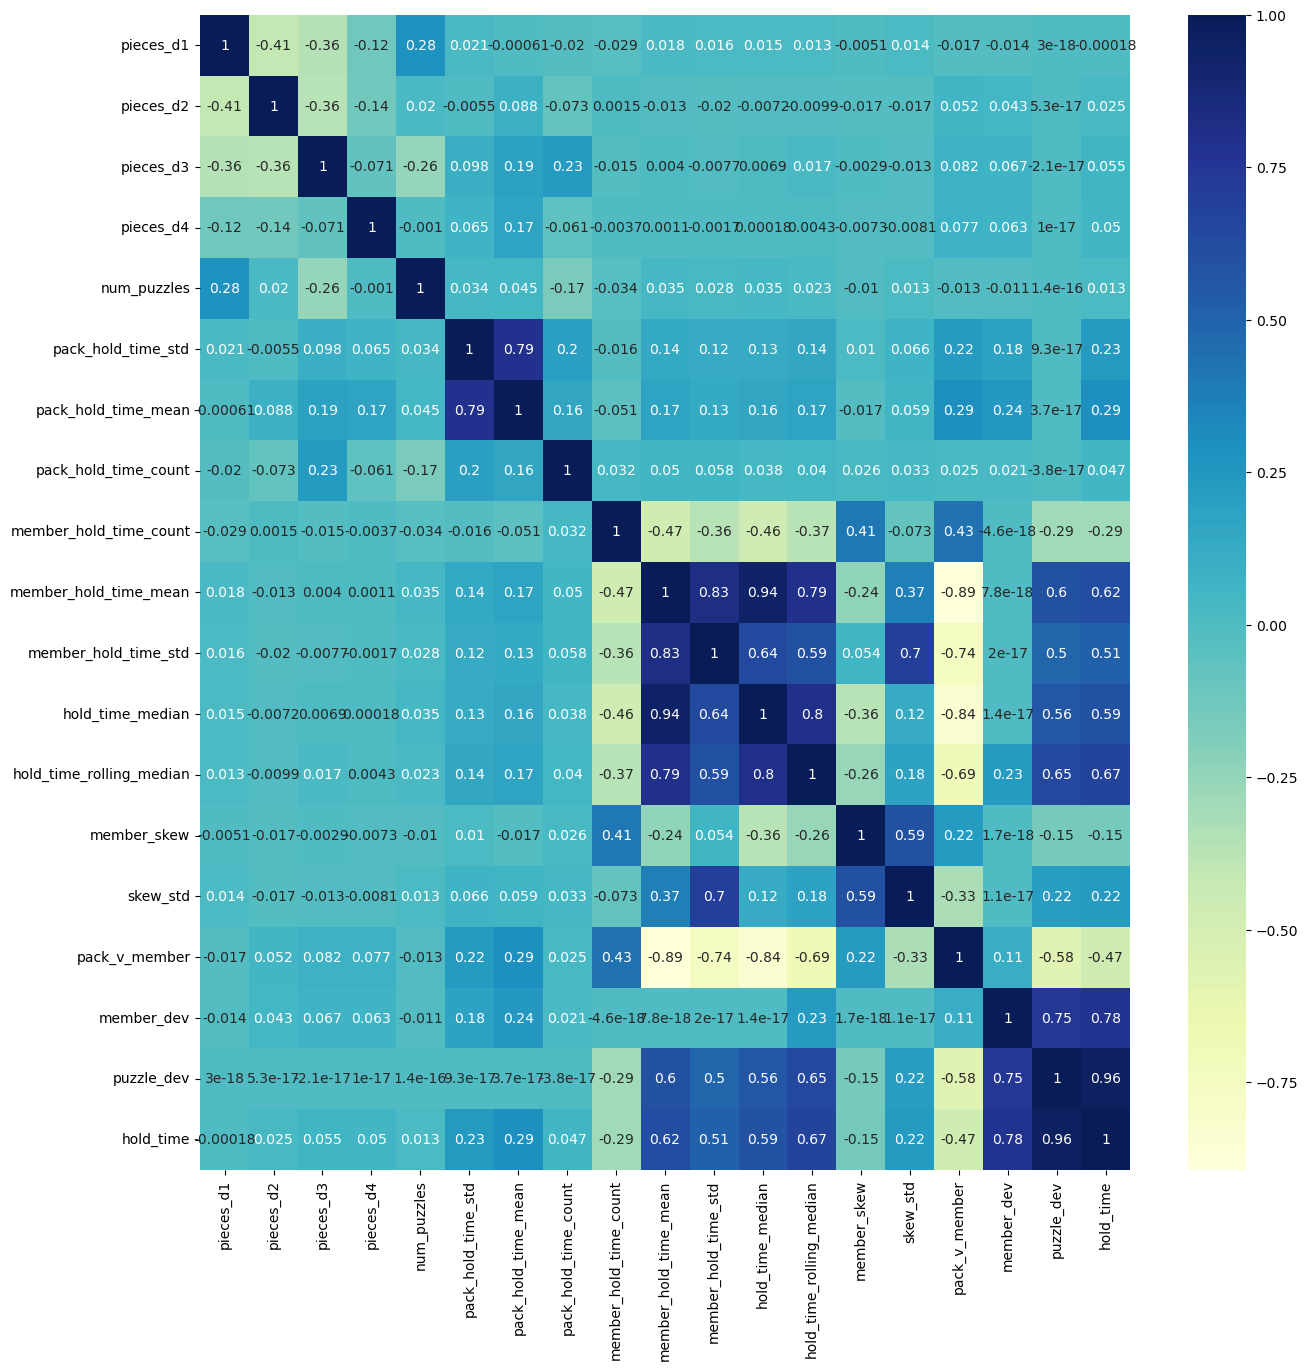

In [481]:
# plotting correlation heatmap
X_train_numeric = pd.merge(X_train, full_training_set.groupby(by='member')['hold_time'].skew(), left_on='member', right_index=True, how='left')
X_train_numeric = X_train_numeric.drop(['member', 'global_hold_time_mean'], axis=1)
X_train_numeric = X_train_numeric.rename({'hold_time': 'member_skew'}, axis=1)
print(X_train_numeric.head())
X_train_numeric['skew_std'] = X_train_numeric['member_skew'] * X_train_numeric.member_hold_time_std
X_train_numeric['skew_std'] = X_train_numeric['member_skew'] * X_train_numeric.member_hold_time_std
X_train_numeric['pack_v_member'] = X_train_numeric.pack_hold_time_mean - X_train_numeric.member_hold_time_mean
X_train_numeric['member_dev'] = (y_train - X_train_numeric['member_hold_time_mean'])
X_train_numeric['puzzle_dev'] = (y_train - X_train_numeric['pack_hold_time_mean'])
X_train_numeric['hold_time'] = y_train
plt.figure(figsize=(15,15))
dataplot = sns.heatmap(X_train_numeric.corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
plt.show()

<AxesSubplot: >

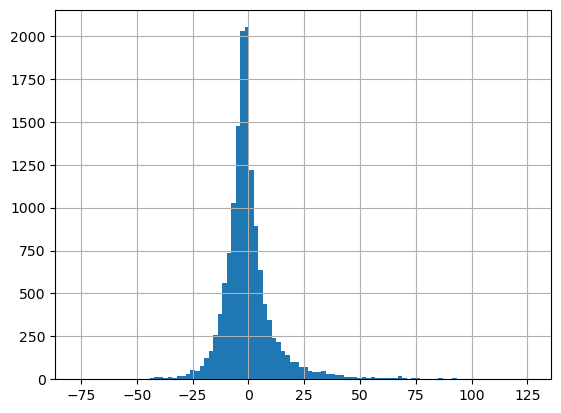

In [482]:
X_train_numeric.member_dev.hist(bins=100)

<AxesSubplot: xlabel='member_skew', ylabel='member_dev'>

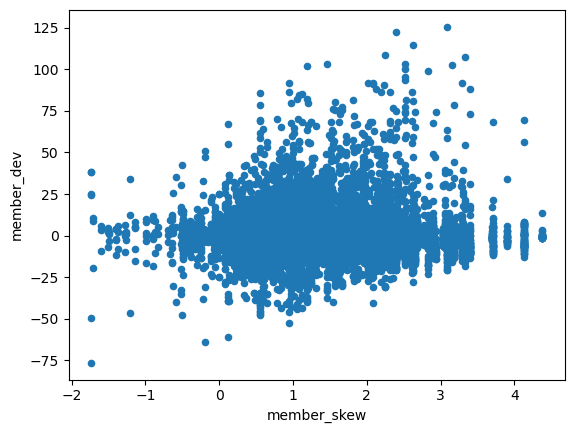

In [483]:
X_train_numeric.plot(x='member_skew', y='member_dev', kind='scatter')

In [484]:
# Dropping some things to see
#X_train = X_train.drop(['member_hold_time_mean', 'member_hold_time_std', 'member_hold_time_count', 'pack_hold_time_count'], axis=1)
#X_test = X_test.drop(['member_hold_time_mean', 'member_hold_time_std', 'member_hold_time_count', 'pack_hold_time_count'], axis=1)

X_train = X_train.drop(['pack_hold_time_mean', 'pack_hold_time_std', 'pack_hold_time_count', 'num_puzzles'], axis=1)
X_test = X_test.drop(['pack_hold_time_mean', 'pack_hold_time_std', 'pack_hold_time_count', 'num_puzzles'], axis=1)

In [485]:
# TRY PREDICTING DEVIATION FROM HISTORIC MEAN INSTEAD
y_train_old = y_train.copy()
y_test_old = y_test.copy()
y_train = y_train - X_train.member_hold_time_mean
y_test = y_test - X_test.member_hold_time_mean


<AxesSubplot: >

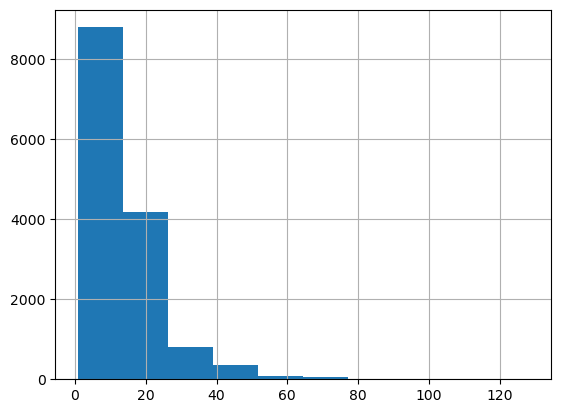

In [486]:
X_train.member_hold_time_mean.hist()

In [487]:
record_counts = X_train.member.value_counts()
record_counts

member593    146
member505    130
member311    103
member40      99
member442     98
            ... 
member2        1
member13       1
member598      1
member377      1
member177      1
Name: member, Length: 663, dtype: int64

In [488]:
MAX_STD = 5000
MIN_HISTORY = 75 # Minimum number of data points for a member to get their own model
# 3.6 / 13.2 @ 100
# 3.5 / 12.9 @ 75
# 5.5 / 14.2 @ 50
# 8.5 / 17.2 @ 25
# 11.6 / 22.3 @ 10

In [489]:
# Fit Scaler on all training data
# TODO Try out other scaler
scaler = StandardScaler()
scaler = scaler.fit(X_train.drop(['member', 'pack_name'], axis=1))

In [490]:
X_test.head()

,member,pack_name,pieces_d1,pieces_d2,pieces_d3,pieces_d4,member_hold_time_count,member_hold_time_mean,member_hold_time_std,hold_time_median,hold_time_rolling_median,global_hold_time_mean
28,member1,Wentworth Puzzles Richard Macneil Summer Hedge...,0,1000,0,0,28.0,5.702647,5.707372,3.003357,3.003357,13.91171
29,member1,Mr. Bob Puzzles Rebecca Cool Birds in a Tree H...,525,253,0,0,28.0,5.702647,5.707372,3.003357,3.003357,13.91171
30,member1,Chris Yates Remote Archipelago BCB Puzzles The...,61,0,0,150,28.0,5.702647,5.707372,3.003357,3.003357,13.91171
31,member1,DaVici Puzzles Heavenly Postman DaVici Puzzles...,430,0,0,0,28.0,5.702647,5.707372,3.003357,3.003357,13.91171
32,member1,Liberty Puzzles Richard Dadd The Fairy Fellers...,0,0,480,0,28.0,5.702647,5.707372,3.003357,7.832772,13.91171


In [491]:
def train_linear_regression(X, y, scaler):
    '''
    Trains linear regression model using the given X, y, and scaler
    
    Returns the trained model
    '''
    
    lr = linear_model.LinearRegression()
    
    # Scale X
    X_s = scaler.transform(X)
    #X_s = X.to_numpy()
    # Fit linear regression model
    lr.fit(X_s, y)
    
    return lr

In [492]:
# For each member with more than MIN_HISTORY data points, train a linear regression model for them and save
# Filter to members with more than MIN_HISTORY points
members = record_counts[(record_counts >= MIN_HISTORY)]
for member, c in members.items():
    # Require a max std in hold, only learn for people who seem stable
    member_std = hold_summary_by_member.loc[member]
    if member_std['std'] > MAX_STD:
        continue
        
    X_train_m = X_train[X_train['member'] == member]
    y_train_m = y_train[X_train['member'] == member]
    
    m = train_linear_regression(X_train_m.drop(['member', 'pack_name'], axis=1), y_train_m, scaler)
    
    # Save model for later use
    with open(f'user_models/{member}.pkl', 'wb') as f:
        pickle.dump(m, f)

In [493]:
# Create a overall model on all data points for use on users without MIN_HISTORY data points
overall_m = train_linear_regression(X_train.drop(['member', 'pack_name'], axis=1), y_train, scaler)
with open(f'user_models/universal.pkl', 'wb') as f:
    pickle.dump(overall_m, f)

In [494]:
# Create model just on users with less than MIN_HISTORY data points as a "new puzzler" model
newps = record_counts[record_counts < MIN_HISTORY].index
X_train_newps = X_train[X_train['member'].isin(newps)]
y_train_newps = y_train[X_train['member'].isin(newps)]
newps_m = train_linear_regression(X_train_newps.drop(['member', 'pack_name'], axis=1), y_train_newps, scaler)
with open(f'user_models/newps.pkl', 'wb') as f:
    pickle.dump(newps_m, f)

In [495]:
def make_pred(X, member, default):
    '''
    args:
        - X - scaled input data
        - member - member string
        - default - default model to use
        
    Look up the proper model and use it, if not use default model
    
    Returns the (predicted hold time, the model used)
    '''
    
    # Check if trained model for member exists
    path = f'user_models/{member}.pkl'

    if os.path.exists(path):
        m = pickle.load(open(path, 'rb'))
        
        return (m.predict(X), member)
        
    else:
        # Use default model
        return (default.predict(X), "default")

In [496]:
# Go through test set and either use the per user model or the universal model
univ_model = pickle.load(open('user_models/universal.pkl', 'rb'))
newps_model = pickle.load(open('user_models/newps.pkl', 'rb'))
print(X_train.drop(['member', 'pack_name'], axis=1).columns)
print(f"Universal Coef {univ_model.coef_}")
print(f"Newps Coef {newps_model.coef_}")
# Scale test data using scaler fit on the training data

X_test_members = X_test['member']
X_test_packs = X_test['pack_name']
X_test_scaled = scaler.transform(X_test.drop(['member', 'pack_name'], axis=1))
#X_test_scaled = X_test.drop(['member', 'pack_name'], axis=1).to_numpy()

Index(['pieces_d1', 'pieces_d2', 'pieces_d3', 'pieces_d4',
       'member_hold_time_count', 'member_hold_time_mean',
       'member_hold_time_std', 'hold_time_median', 'hold_time_rolling_median',
       'global_hold_time_mean'],
      dtype='object')
Universal Coef [ 1.82406926e+00  2.38836643e+00  2.38540074e+00  1.49342888e+00
 -7.07107059e-02 -2.85327726e+00  7.98893400e-03 -4.08959826e+00
  8.37142834e+00  0.00000000e+00]
Newps Coef [ 1.89533032  2.47786508  2.4765758   1.53903089 -0.12909683 -2.96589424
  0.17861954 -4.05496226  8.3059369   0.        ]


In [497]:
y_pred_universal, y_pred_universal_models = zip(*[make_pred(x.reshape(1, -1), m, univ_model) for x, m in zip(X_test_scaled, X_test_members)])
y_pred_universal = np.array(list(y_pred_universal))
y_pred_universal_models = np.array(list(y_pred_universal_models))
mse_univ = mean_squared_error(y_test, y_pred_universal)
mae_univ = mean_absolute_error(y_test, y_pred_universal)
print(f'Using universal default combined mse: {mse_univ}, mae: {mae_univ}')

mse_univ_usermodel = mean_squared_error(y_test[y_pred_universal_models != "default"], y_pred_universal[y_pred_universal_models != "default"])
mae_univ_usermodel = mean_absolute_error(y_test[y_pred_universal_models != "default"], y_pred_universal[y_pred_universal_models != "default"])
print(f'Using universal, user mse: {mse_univ_usermodel}, mae: {mae_univ_usermodel}')

mse_univ_default = mean_squared_error(y_test[y_pred_universal_models == "default"], y_pred_universal[y_pred_universal_models == "default"])
mae_univ_default = mean_absolute_error(y_test[y_pred_universal_models == "default"], y_pred_universal[y_pred_universal_models == "default"])
print(f'Using universal, default mse: {mse_univ_default}, mae: {mae_univ_default}')

Using universal default combined mse: 426.098355759701, mae: 11.5941912302659
Using universal, user mse: 85.0908146289054, mae: 4.790046535235922
Using universal, default mse: 466.484756756146, mae: 12.400023603298127


In [498]:
y_pred_newps, y_pred_newps_models = zip(*[make_pred(x.reshape(1, -1 ), m, newps_model) for x, m in zip(X_test_scaled, X_test_members)])
y_pred_newps = np.array(list(y_pred_newps))
y_pred_newps_models = np.array(list(y_pred_newps_models))
mse_newps = mean_squared_error(y_test, y_pred_newps)
mae_newps = mean_absolute_error(y_test, y_pred_newps)
print(f'Using newps combined mse: {mse_newps}, mae: {mae_newps}')

mse_newps_usermodel = mean_squared_error(y_test[y_pred_newps_models != "default"], y_pred_newps[y_pred_newps_models != "default"])
mae_newps_usermodel = mean_absolute_error(y_test[y_pred_newps_models != "default"], y_pred_newps[y_pred_newps_models != "default"])
print(f'Using newps, user mse: {mse_newps_usermodel}, mae: {mae_newps_usermodel}')

mse_newps_default = mean_squared_error(y_test[y_pred_newps_models == "default"], y_pred_newps[y_pred_newps_models == "default"])
mae_newps_default = mean_absolute_error(y_test[y_pred_newps_models == "default"], y_pred_newps[y_pred_newps_models == "default"])
print(f'Using newps, default mse: {mse_newps_default}, mae: {mae_newps_default}')


Using newps combined mse: 425.56468159994176, mae: 11.598147557972968
Using newps, user mse: 85.0908146289054, mae: 4.790046535235922
Using newps, default mse: 465.8878781917392, mae: 12.404448489080837


In [499]:
y_pred_newps

array([[ 2.39671003],
       [-0.12928223],
       [-3.3465122 ],
       ...,
       [ 4.56286798],
       [ 1.55778804],
       [ 0.7570273 ]])

In [500]:
mean_absolute_error([y_train.mean()] * len(y_test), y_test)

13.019449625383578

In [501]:
set(y_pred_universal_models[y_pred_universal_models != "default"])

{'member121',
 'member170',
 'member298',
 'member311',
 'member348',
 'member359',
 'member368',
 'member390',
 'member393',
 'member40',
 'member429',
 'member442',
 'member457',
 'member505',
 'member533',
 'member593',
 'member649'}

In [502]:
print(len(y_test))
print(len(y_test[y_pred_newps_models != "default"]))
print(len(y_test[(y_pred_newps_models != "default") & (X_test_not_missing)]))
mean_absolute_error(y_test[(y_pred_newps_models != "default") & (X_test_not_missing)], y_pred_newps[(y_pred_newps_models != "default") & (X_test_not_missing)])

5109
541
541


4.790046535235922

In [503]:
file = glob.glob('user_models/*')
for f in file:
    os.remove(f)
    pass

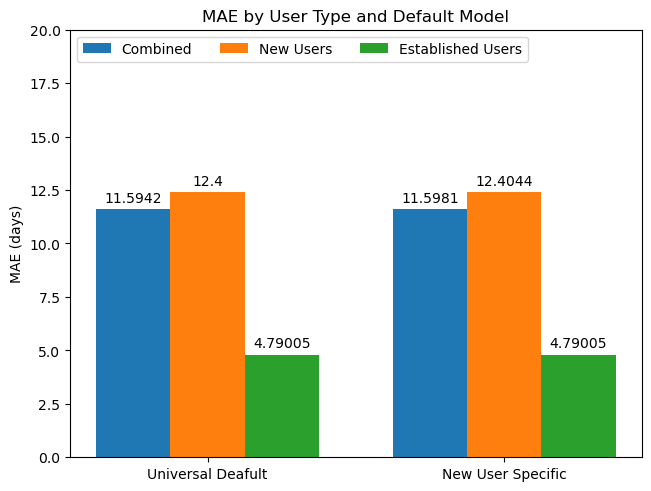

In [504]:
approaches = ("Universal Deafult", "New User Specific")
model_mae = {
    "Combined": (mae_univ, mae_newps),
    "New Users": (mae_univ_default, mae_newps_default),
    "Established Users": (mae_univ_usermodel, mae_newps_usermodel)
}

x = np.arange(len(approaches))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for model, mae in model_mae.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, mae, width, label=model)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MAE (days)')
ax.set_title('MAE by User Type and Default Model')
ax.set_xticks(x + width, approaches)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 20)

plt.show()

In [505]:
diff = y_test - y_pred_newps.flatten()

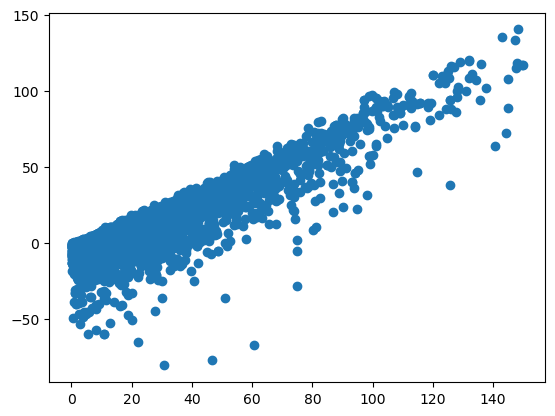

In [506]:
plt.scatter(y_test_old, y_test)

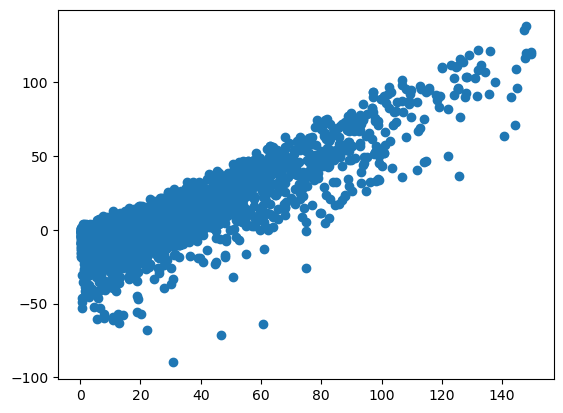

In [507]:
plt.scatter(y_test_old, diff)